# rocal runned

In [1]:
# 기본 작업 경로 설정
import os
notebook_path = os.path.abspath("project_3_git/readme.md")
notebook_dir = os.path.dirname(notebook_path)
os.chdir(notebook_dir)

# 현재 작업 디렉토리 출력
print("Current working directory: ", os.getcwd())

Current working directory:  /mnt/e/py_data/project_3_git


In [28]:
import json
import random

# JSON 파일에서 딕셔너리 읽기
with open('data/text_data/output_text.json', 'r') as file:
    data_loaded = json.load(file)

# 데이터 섞기
items = list(data_loaded.items())
random.shuffle(items)

# 데이터를 섞은 후 딕셔너리로 변환
data_loaded_shuffled = dict(items)


In [29]:
# 학습 및 테스트 데이터셋 나누기
train_x = [data_loaded_shuffled[i][0] for i in data_loaded_shuffled][:5000]
train_y = [data_loaded_shuffled[i][1] for i in data_loaded_shuffled][:5000]
test_x = [data_loaded_shuffled[i][0] for i in data_loaded_shuffled][5000:]
test_y = [data_loaded_shuffled[i][1] for i in data_loaded_shuffled][5000:]

In [30]:
name_folder = 'models/gpt2/kogpt2_1_1/'
server_port = '6006'
batch_size = 16
train_epochs = 100

In [31]:
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import Dataset
from transformers import PreTrainedTokenizerFast

# 모델 로드('skt/kogpt2-base-v2')
model_name = "skt/kogpt2-base-v2"
model = GPT2LMHeadModel.from_pretrained(model_name)

# 토크나이저 로드

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/home/tommy/miniconda3/envs/p3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
# 데이터 전처리 함수 정의
def preprocess_function(examples):
    model_inputs = tokenizer(examples['input_text'], max_length=128, truncation=True, padding='max_length')
    labels = tokenizer(examples['target_text'], max_length=128, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [33]:
# 데이터셋 생성 및 토큰화
dataset_train = Dataset.from_dict({'input_text': train_x,'target_text': train_y})
dataset_test = Dataset.from_dict({'input_text': test_x,'target_text': test_y})

tokenized_train_datasets = dataset_train.map(preprocess_function, batched=True)
tokenized_test_datasets = dataset_test.map(preprocess_function, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████████| 994/994 [00:00<00:00, 9626.54 examples/s]


In [34]:
# 학습인자
training_args = TrainingArguments(
    per_device_train_batch_size=batch_size, # 학습 배치 사이즈
    per_device_eval_batch_size=batch_size,  # 평가 배치 사이즈
    output_dir=f'{name_folder}',         # 모델 및 체크포인트 저장 디렉토리
    num_train_epochs=train_epochs,          # 학습 에폭 수
    logging_dir=f'{name_folder}/logs',   # TensorBoard 로그가 저장될 디렉토리
    logging_steps=100,                      # TensorBoard 로그를 기록할 간격
    report_to='tensorboard',                # TensorBoard로 로깅
    load_best_model_at_end = True,
    eval_strategy='epoch',
    save_strategy='epoch',                  # 에포크 마다 모델 저장
    # resume_from_checkpoint=True           # 이어 학습

    # 추가 인자
    learning_rate=5e-5,                     # 기본값에서 시작
    lr_scheduler_type="linear",             # 스케줄러
    warmup_steps=500,                       # 500 스텝 동안 학습률을 점진적으로 증가
    weight_decay=0.01,                      # l2 정규화 기법 중 하나
    max_grad_norm=1.0,                      # 그라디언트 클리핑
)

In [35]:
# Trainer 객체 생성
from transformers.trainer_callback import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1000)]
)

In [36]:
# 모델 학습
trainer.train() # 이어 학습시 (resume_from_checkpoint=checkpoint_dir)

Epoch,Training Loss,Validation Loss
1,0.852300,0.798793
2,0.773900,0.777139


KeyboardInterrupt: 

In [ ]:
# 모델과 토크나이저 저장
model_save_path = 'models/gpt2/kogpt2_1/model'
tokenizer_save_path = 'models/gpt2/kogpt2_1/model/tokenizer'

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"모델이 '{model_save_path}'에 저장되었습니다.")
print(f"토크나이저가 '{tokenizer_save_path}'에 저장되었습니다.")

모델이 'models/gpt2/kogpt2_1/model'에 저장되었습니다.
토크나이저가 'models/gpt2/kogpt2_1/model/tokenizer'에 저장되었습니다.


In [ ]:
text_intput_text = '슬픔, 분노'

In [63]:
import torch

model = GPT2LMHeadModel.from_pretrained('models/gpt2/kogpt2_1/model')
# tokenizer = GPT2Tokenizer.from_pretrained('models/gpt2/kogpt2_1/model/tokenizer')

# 테스트 입력
test_input = test_x[1]
# 입력 토큰화
input_ids = tokenizer.encode(test_input, return_tensors='pt')

# 모델 예측
with torch.no_grad():
    outputs = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)

# 예측 결과 디코딩
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"테스트 입력: {test_input}")
print(f"모델의 예측: {predicted_text}")


테스트 입력: 기쁨, 재킷
모델의 예측: 기쁨, 재킷시네네네네네네네네네네네네네네네네네네


In [40]:
device = torch.device("cuda")

In [108]:
test_input = '기쁨, 슬픔'

In [109]:
# 평가 모드로 변경

model.eval()
model.to(device)

def generate_text(prompt, model, tokenizer, max_length=50, num_return_sequences=5):
    # 입력 텍스트를 토큰화
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 생성 인자를 설정하여 모델이 텍스트를 생성
    outputs = model.generate(
        inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=1.9,
        do_sample=True,
        early_stopping=True
    ).to(device)

    # 생성된 텍스트를 디코딩
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    
    return generated_texts

generated_texts = generate_text('입력값:'+test_input+'\n출력값:', model, tokenizer)
    
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:")
    print(text)
    print()

/home/tommy/miniconda3/envs/p3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Text 1:
입력값:기쁨, 슬픔
출력값:!? 무슨인지 궁금 모습이 어떤 일이네? 건 걸데, 정말 잘 일이 멋진! 정말 멋? 스타 것!가네 무슨 잘 멋진다이 모습이

Generated Text 2:
입력값:기쁨, 슬픔
출력값:나해?해 힘든가 멋진? 액 액니! 색 어떤데,경도니 조 안지시 안린지 차네경이요 안 오토신지시 멋진요.

Generated Text 3:
입력값:기쁨, 슬픔
출력값:가 힘 모습이 일이 매력 어떤나 독특?! 어떤네네 멋진데,네 모습이하가 무슨 건!!세데, 건네뭘!경이일리인지

Generated Text 4:
입력값:기쁨, 슬픔
출력값: 잘 걸 계신신지네 정말 독특 궁금신 멋진 멋 궁금셨! 정말 편의네 재 점에서 일이 흥미다일이요.요!!요

Generated Text 5:
입력값:기쁨, 슬픔
출력값: 건 힘든 일이요 데, 있었던가 일이일리 멋진 멋진 건 무슨네 일이 모습이요세 일을 모습이 일이네 모습이! 작업이 걸지 액 일을 액요



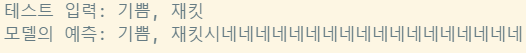